# Lasso

## Basics

Lasso performs a so called `L1 regularization` (a process of introducing additional information in order to prevent overfitting), i.e. adds penalty equivalent to absolute value of the magnitude of coefficients.

In particular, the minimization objective does not only include the residual sum of squares (RSS) - like in the OLS regression setting - but also the sum of the absolute value of coefficients.

The residual sum of squares (RSS) is calculated as follows:

$$ RSS = \sum_{i=1}^{n} (y_i - \hat{y_i})^2 $$

This formula can be stated as:

$$ RSS = \sum_{i=1}^{n} \bigg(y_i - \big( \beta_{0} + \sum_{j=1}^{p} \beta_{j} x_{ij} \big) \bigg)^2  $$

- $n$ represents the number of distinct data points, or observations, in our sample.
- $p$ denotes the number of variables that are available in the dataset.
- $x_{ij}$ represents the value of the jth variable for the ith observation, where i = 1, 2, . . ., n and j = 1, 2, . . . , p.

In the lasso regression, the minimization objective becomes:

$$ \sum_{i=1}^{n} \bigg(y_i - \big( \beta_{0} + \sum_{j=1}^{p} \beta_{j} x_{ij} \big) \bigg)^2 + \lambda \sum_{j=1}^{p} |\beta_j|   $$

which equals:

$$RSS + \lambda \sum_{j=1}^{p} |\beta_j|  $$


$\lambda$ (lambda) provides a trade-off between balancing RSS and magnitude of coefficients.

$\lambda$ can take various values:

  - $\lambda$ = 0: Same coefficients as simple linear regression
  - $\lambda$ = ∞: All coefficients zero (same logic as before)
  - 0 < $\lambda$ < ∞: coefficients between 0 and that of simple linear regression

## Python setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Import data

This notebook involves the use of the Lasso regression on an automobile dataset. 

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Auto.csv")

In [3]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


## Tidying data

We only use observations 1 to 200 for our analysis and drop the `name` variable.

In [5]:
df = df.iloc[0:200]
df = df.drop(['name'], axis=1)

In [6]:
df['origin'] = pd.Categorical(df['origin'])
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

print(df.isnull().sum())

mpg             0
cylinders       0
displacement    0
horsepower      2
weight          0
acceleration    0
year            0
origin          0
dtype: int64


In [8]:
# drop missing cases
df = df.dropna()

## Transform data

In [17]:
# Convert all columns to integer
df = df.astype('int')

### Split data

Split the data set into train and test sets (use `X_train`, `X_test`, `y_train`, `y_test`), with the first 75% of the data for training and the remaining for testing. (module: `from sklearn.model_selection import train_test_split`)

In [18]:
X = df.drop(['mpg'], axis=1)
y = df['mpg']

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

### Standardization

*Standardize the features with the module: `from sklearn.preprocessing import StandardScaler`*

It is important to standardize the features by removing the mean and scaling to unit variance. The L1 (Lasso) and L2 (Ridge) regularizers of linear models assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [11]:
dfs.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin'],
      dtype='object')

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


## Model

Apply **Lasso regression** on the training set with the regularization parameter **lambda = 0.5** (module: `from sklearn.linear_model import Lasso`) and print the $R^2$-score for the training and test set. Comment on your findings.

In [24]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

Lasso(alpha=0.5)

In [29]:
print('Lasso Regression: R squared score on training set', round(reg.score(X_train, y_train)*100, 2))
print('Lasso Regression: R squared score on test set', round(reg.score(X_test, y_test)*100, 2))

Lasso Regression: R squared score on training set 82.48
Lasso Regression: R squared score on test set 84.55


### Tune lambda

#### Fit models

Apply the **Lasso regression** on the training set with the following **λ parameters: (0.001, 0.01, 0.1, 0.5, 1, 2, 10)**. 

Evaluate the $R^2$ score for all the models you obtain on both the train and test sets.

In [30]:
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

In [31]:
# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

In [32]:
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

#### Plot result

Plot all values for both data sets (train and test $R^2$-values) as a function of λ. Note that we use the index of the values at the x-axis, not the values themselves. 

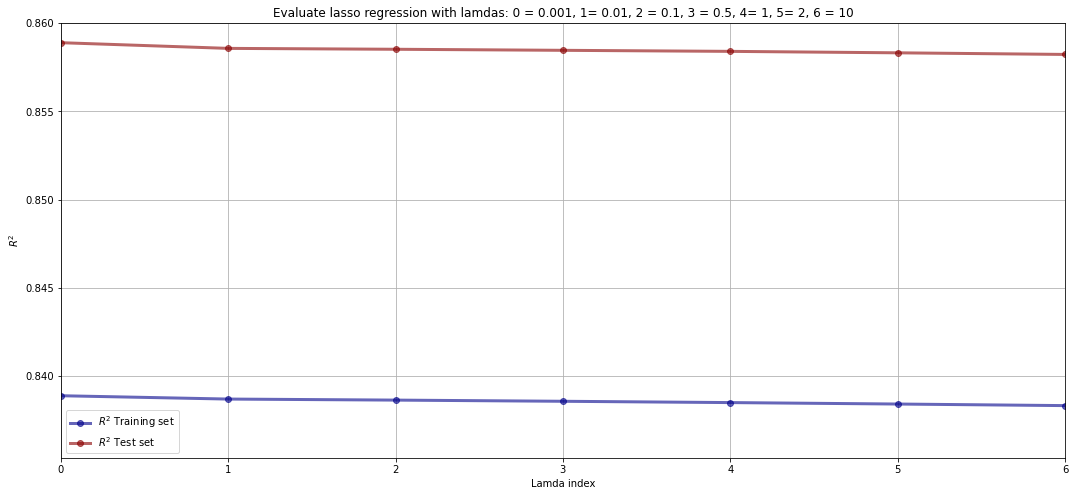

In [50]:
plt.figure(figsize=(18, 8))

plt.plot(train_r_squared, 'o-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'o-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)

plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

#### Identify best lambda

Store your test data results in a DataFrame and indentify the lambda where the $R^2$ has it's **maximum value** in the **test data**. 

In [37]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    86.069153
lambda        0.001000
Name: 0, dtype: float64

Fit a Lasso model with this lambda parameter (use the training data) and obtain the corresponding **regression coefficients**. 


In [38]:
reg_best = Lasso(alpha = 0.1)
reg_best.fit(X_train, y_train)
reg_best.coef_

array([-3.59692164e-01, -1.14969745e+00, -3.14657390e-03, -3.38035561e+00,
       -0.00000000e+00,  3.73181500e-01,  7.53577777e-01])

Obtain the **mean squared error** for the test data of this model (module: `from sklearn.metrics import mean_squared_error`)

In [39]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, reg_best.predict(X_test))

4.139676038691059

## Tune with k-fold cross validation

Evaluate the performance of a Lasso regression for different regularization parameters λ using **5-fold cross validation** on the training set (module: `from sklearn.model_selection import cross_val_score`) and plot the cross-validation (CV) $R^2$ scores of the training and test data as a function of λ.


 We use the following lambda parameters:

In [40]:
l_min = 0.05
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

In [41]:
# data preparation
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

In [42]:
# models
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=5, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

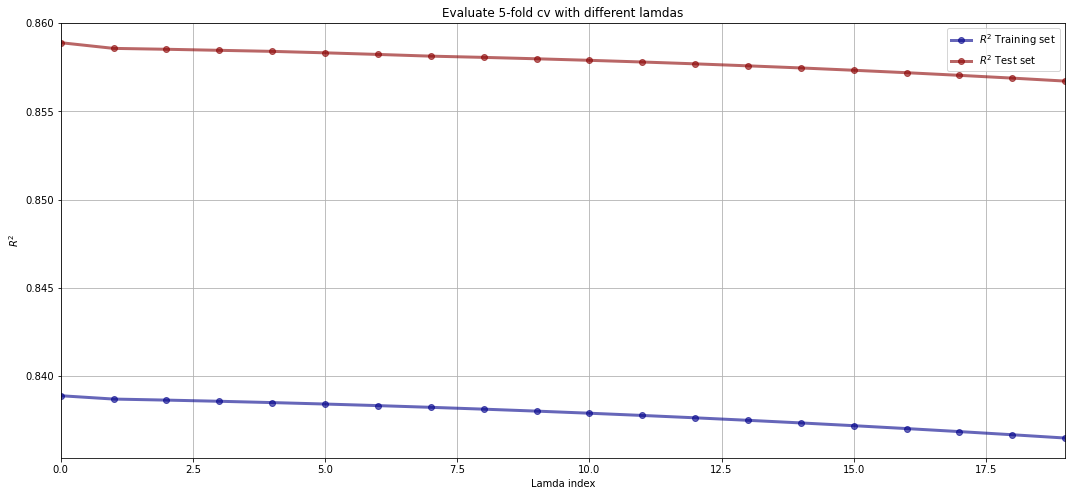

In [54]:
# Plotting
plt.figure(figsize=(18, 8))

plt.plot(train_r_squared, 'o-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'o-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)

plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

Finally, store your test data results in a DataFrame and identify the lambda where the $R^2$ has it's **maximum value** in the **test data**. 

In [51]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    85.889304
lambda        0.050000
Name: 0, dtype: float64

Fit a Lasso model with this lambda parameter (use the training data) and obtain the corresponding **regression coefficients**. Furthermore, obtain the **mean squared error** for the test data of this model (module: `from sklearn.metrics import mean_squared_error`)

In [55]:
# Best Model
reg_best = Lasso(alpha = 0.05)
reg_best.fit(X_train, y_train)

Lasso(alpha=0.05)

In [56]:
mean_squared_error(y_test, reg_best.predict(X_test))

4.119250902549809

In [57]:
reg_best.coef_

array([-0.38405539, -1.08687731, -0.04867365, -3.41242241, -0.02807974,
        0.42234148,  0.79308801])